In [1]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import pandas as pd
import numpy as np

from matplotlib import pyplot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime

In [2]:
#airpassengers = pm.datasets.load_airpassengers()
dateparse = lambda x: datetime.strptime(x, '%Y-%m')
airpassengers = pd.read_csv('airline-passengers.csv',header = 0, parse_dates = [0], date_parser = dateparse)
airpassengers.set_index('Month', inplace = True)


<AxesSubplot:xlabel='Month'>

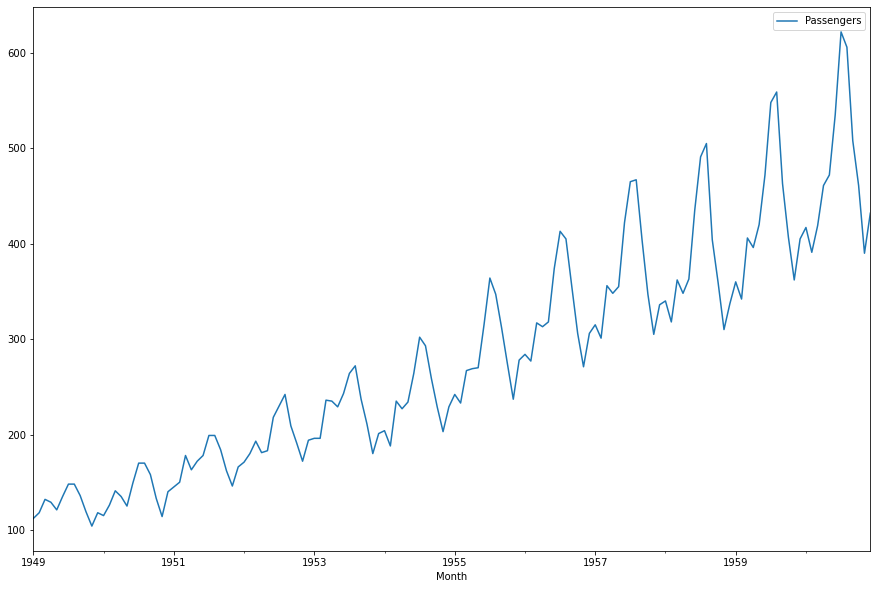

In [3]:
airpassengers.plot(figsize = (15,10))

## ACF function shows correlation between the original series and lagged series

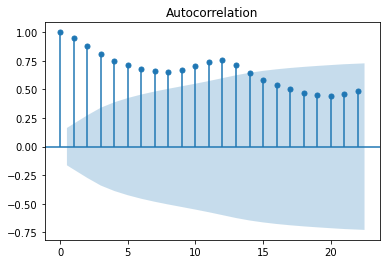

In [4]:
plot_acf(airpassengers)
pyplot.show()

## PACF - a Partial ACF shows a correlation between series and lagged observation excluding the effect of intermediate lag components

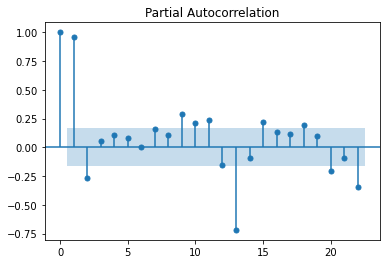

In [5]:
plot_pacf(airpassengers)
pyplot.show()

## Time Series decomposition into Trend, Seasonal and Noise components

Multiplicative model is assumed: Y(t) = T(t) * S(t) * N(t)

In [6]:
decomposed = pm.decompose(np.array(airpassengers['Passengers']), 'multiplicative', m=12)

Text(0.5, 1.0, 'Passengers Seasonal Decomposition')

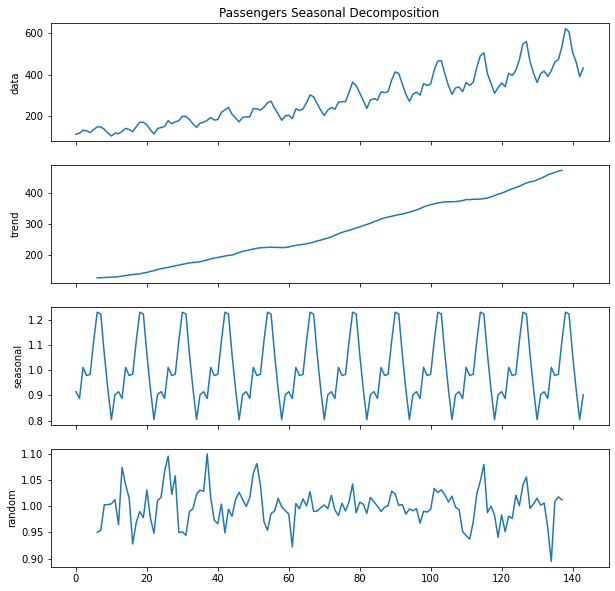

In [7]:
axes = pm.utils.decomposed_plot(decomposed, figure_kwargs={'figsize': (10, 10)}, show=False)
axes[0].set_title("Passengers Seasonal Decomposition")

## Transformations for Stationarity (Diff, Log)

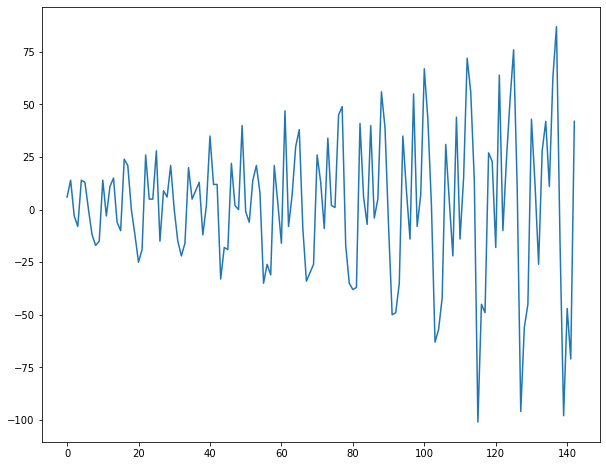

In [8]:
# Removing the trend with the lag 1 differencing

first_order_lag_1 = pm.utils.diff(airpassengers, 1, 1)
pyplot.figure(figsize = (10,8))
pyplot.plot(first_order_lag_1)

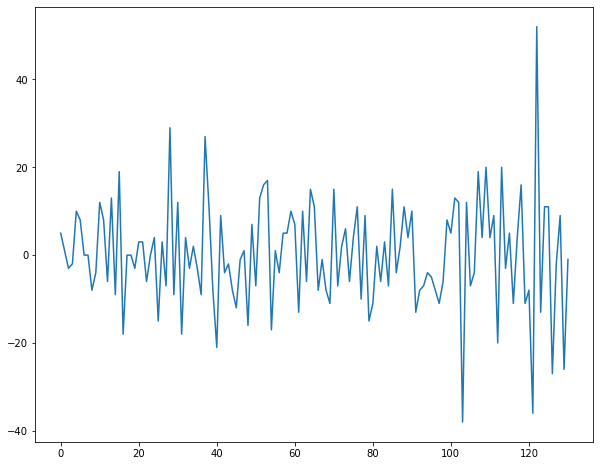

In [9]:
# Stabilizing the variance via seasonal differencing
first_order_seasonal_lag = pm.utils.diff(first_order_lag_1, 12, 1)
pyplot.figure(figsize = (10,8))
pyplot.plot(first_order_seasonal_lag)

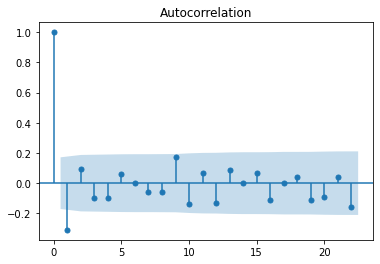

In [10]:
plot_acf(first_order_seasonal_lag)
pyplot.show()

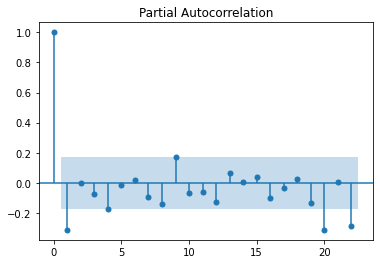

In [11]:
plot_pacf(first_order_seasonal_lag)
pyplot.show()

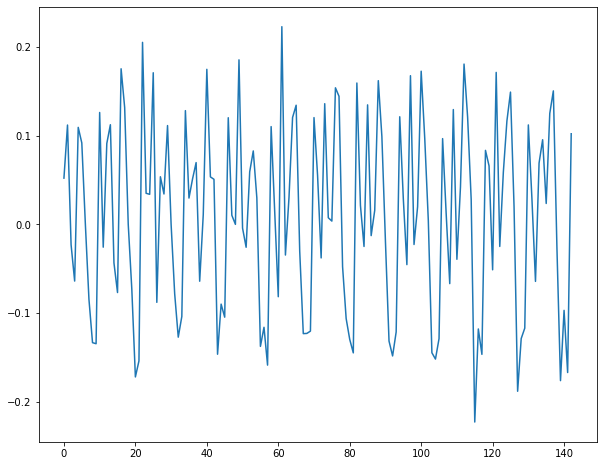

In [12]:
# Alternative way to turn the series into a stationary process

log_differencing = pm.utils.diff(np.log(airpassengers), 1, 1)
pyplot.figure(figsize = (10,8))
pyplot.plot(log_differencing)

## ARIMA model

In [13]:
y_train, y_test = train_test_split(airpassengers, test_size=36)

In [14]:
stepwise_fit = pm.auto_arima(y_train, start_p=0, start_q=0,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             start_d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=706.721, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.730, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=704.186, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=704.801, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=704.001, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.472, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.993, Time=0.21 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=705.691, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=705.081, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=704.376, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=707.075, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=705.875, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.855 seconds


In [15]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Wed, 03 Feb 2021   AIC                            704.001
Time:                                    11:52:25   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439      6.902      0.000      66.410     119.090
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.92   Prob(JB):                         0.31
Heteroskedasticity (H):               0.92   Skew:                             0.38
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
forecast = stepwise_fit.predict(n_periods=36)

In [17]:
y_test['Forecast'] = forecast

<ipython-input-17-b17dac709bfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Forecast'] = forecast


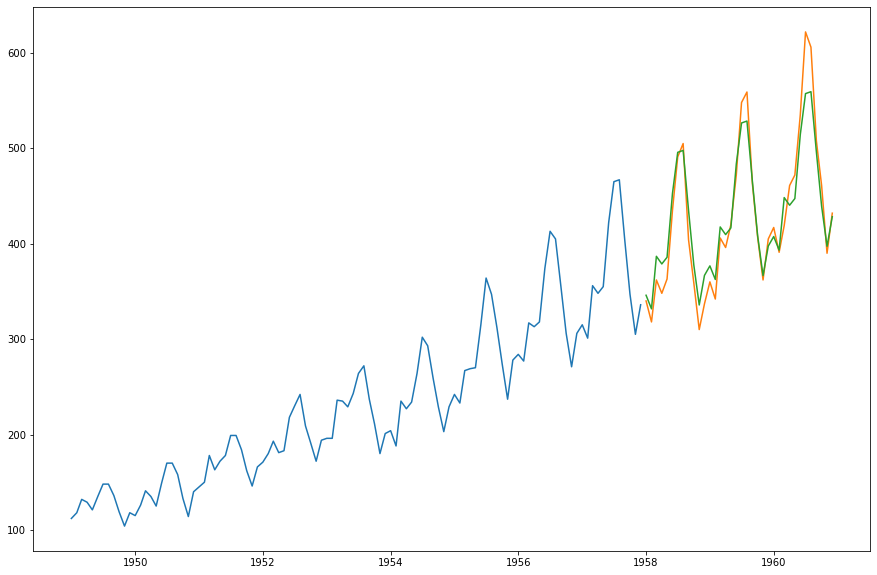

In [21]:
pyplot.figure(figsize = (15,10))
pyplot.plot(y_train)
pyplot.plot(y_test)

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mean_absolute_percentage_error(y_test['Passengers'], y_test['Forecast'])

4.148971438651082